In [1]:
import functools as ft
import os
from pathlib import Path

import equinox as eqx
import jax.profiler
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from einops import repeat
from ipywidgets import interact
from ising.config import Config, JaxPlatform
from ising.primitives.utils import beta_to_temp
from ising.state import Environment, State
from ising.types import Algorithm
from ising.utils.random import EasyKey
from jax import config, device_count, random
from scipy import constants
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
PAPERMILL: bool = False
PAPERMILL_INPUT_PATH: str = ""
PAPERMILL_OUTPUT_PATH: str = ""

In [3]:
# base
JAX_PLATFORM: JaxPlatform = JaxPlatform.TPU
DO_PROFILING: bool = False
ENABLE_64_BIT: bool = False

# experiment
RNG_SEED: int = 0
SPIN: float = 0.5
DIMENSIONS: int = 2
SIZE: int = 16
TOTAL_SAMPLES: int = 512

# thermalisation
THERMALISE_STEPS: int = 50
THERMALISE_SWEEPS_PER_STEP: int = 25

# environment
INTERACTION_BILINEAR: float = 1.0
INTERACTION_BIQUADRATIC: float = 0.0
INTERACTION_ANISOTROPY: float = 0.0
INTERACTION_BICUBIC: float = 0.0
INTERACTION_EXTERNAL_FIELD: float = 0.0
NUCLEAR_MAGNETIC_MOMENT: float = 1.0

# environment config
ALGORITHM: Algorithm = Algorithm.WOLFF
PROBABILISTIC_CLUSTER_ACCEPT: bool = False

# temperatures
TEMP_MIN: float = 0.50
TEMP_MAX: float = 1.50
N_TEMPS: int = 64

In [4]:
# Parameters
PAPERMILL_INPUT_PATH = "workbench.ipynb"
PAPERMILL_OUTPUT_PATH = "experiments/test/experiment.ipynb"
PAPERMILL = True
RNG_SEED = 1
JAX_PLATORM = "tpu"

In [5]:
# Post init
SAVE_PATH = Path(PAPERMILL_OUTPUT_PATH).parent

_CONFIG_VARS = [
    "JAX_PLATFORM",
    "DO_PROFILING",
    "ENABLE_64_BIT",
    "RNG_SEED",
    "SPIN",
    "DIMENSIONS",
    "SIZE",
    "TOTAL_SAMPLES",
    "THERMALISE_STEPS",
    "THERMALISE_SWEEPS_PER_STEP",
    "INTERACTION_BILINEAR",
    "INTERACTION_BIQUADRATIC",
    "INTERACTION_ANISOTROPY",
    "INTERACTION_BICUBIC",
    "INTERACTION_EXTERNAL_FIELD",
    "NUCLEAR_MAGNETIC_MOMENT",
    "ALGORITHM",
    "PROBABILISTIC_CLUSTER_ACCEPT",
    "TEMP_MIN",
    "TEMP_MAX",
    "N_TEMPS",
]

_CONFIG_DICT = {}

for var in _CONFIG_VARS:
    _CONFIG_DICT[var.lower()] = globals()[var]
    del globals()[var]

c = Config(**_CONFIG_DICT)

if PAPERMILL:
    with open(SAVE_PATH / "config.json", "w") as f:
        f.write(c.json(indent=4))


# ---
match c.jax_platform:
    case JaxPlatform.CPU:
        config.update("jax_platform_name", "cpu")
        config.update("jax_platforms", "cpu")

        # CPU cores as separate devices
        os.environ[
            "XLA_FLAGS"
        ] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

    case JaxPlatform.TPU:
        config.update("jax_platform_name", "tpu")
        config.update("jax_platforms", "tpu")

        # SEE: https://github.com/google/jax/discussions/12001#discussioncomment-3467948
        os.environ["LIBTPU_INIT_ARGS"] = "--xla_tpu_spmd_rng_bit_generator_unsafe=1"
        config.update("jax_default_prng_impl", "unsafe_rbg")

    case JaxPlatform.GPU:
        config.update("jax_platform_name", "gpu")
        config.update("jax_platforms", "gpu")

    case _:
        raise ValueError("Invalid JaxPlatform")

# config.update("jax_check_tracer_leaks", True)
if c.enable_64_bit:
    config.update("jax_enable_x64", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

if "_PROFILER_IS_RUNNING" not in globals() and c.do_profiling:
    _PROFILER_IS_RUNNING = True
    jax.profiler.start_server(9999)

In [6]:
# Init
rng_seed = c.rng_seed if c.rng_seed is not None else np.random.randint(0, 10**10)
k = EasyKey(rng_seed)
rng_key = k.new

ENVIRONMENT_BASE_PARAMS = {
    "interaction_bilinear": c.interaction_bilinear,
    "interaction_biquadratic": c.interaction_biquadratic,
    "interaction_anisotropy": c.interaction_anisotropy,
    "interaction_bicubic": c.interaction_bicubic,
    "interaction_external_field": c.interaction_external_field,
    "nuclear_magnetic_moment": c.nuclear_magnetic_moment,
    "algorithm": c.algorithm,
    "probabilistic_cluster_accept": c.probabilistic_cluster_accept,
}

N_DEVICE_SAMPLES = device_count()

BETA_MIN = 1.0 / c.temp_max
BETA_MAX = 1.0 / c.temp_min
betas = np.geomspace(BETA_MIN, BETA_MAX, c.n_temps)

N_SUBSAMPLES = c.total_samples // (N_DEVICE_SAMPLES * c.n_temps)

_VECTORISED_COUNT = c.n_temps * N_DEVICE_SAMPLES * N_SUBSAMPLES
TOTAL_SWEEPS = _VECTORISED_COUNT * c.thermalise_sweeps_per_step * c.thermalise_steps
print(f"Temperatures: {c.n_temps:_}")
print(f"Vectorised count: {_VECTORISED_COUNT:_}")
print(f"Total sweeps: {TOTAL_SWEEPS:_}")

Temperatures: 64
Vectorised count: 512
Total sweeps: 640_000


In [7]:
# Single state

env = Environment.from_spin(spin=c.spin, beta=1.0, **ENVIRONMENT_BASE_PARAMS)
state = State.uniform_random_square_from_env(
    rng_key=k.new, dimensions=c.dimensions, size=c.size, env=env, id_=0
)

# state = state.evolve_steps(1000, rng_key=k.new)
initial_state = state
state = state.evolve_sweeps(1, rng_key=k.new)
# measured = state.measure(rng_key=k.new, num=1, sweeps=10)

state.calculate_energy()
state.calculate_magnetisation_density()

Array(0.0078125, dtype=float32)

In [8]:
def transforms(in_axes, out_axes):
    def inner(fun):
        fun = eqx.filter_jit(fun)

        # BETAS
        fun = eqx.filter_vmap(in_axes=in_axes, out_axes=out_axes)(fun)

        # N_DEVICES
        fun = eqx.filter_pmap(in_axes=in_axes, out_axes=out_axes)(fun)

        # SUBSAMPLES
        fun = eqx.filter_vmap(in_axes=in_axes, out_axes=out_axes)(fun)

        return fun

    return inner


@transforms(in_axes=(0, None, None, None, 0, 0, None), out_axes=0)
def make_states(rng_key, spin, dimensions, size, beta, id_, kwargs):
    env = Environment.from_spin(
        spin=spin,
        beta=beta,
        **kwargs,
    )

    rng_key, k = random.split(rng_key, num=2)

    state = State.minimum_square_from_env(
        rng_key=k, dimensions=dimensions, size=size, env=env, id_=id_
    )
    # state = State.uniform_random_square_from_env(
    #     rng_key=k, dimensions=dimensions, size=size, env=env, id_=id_
    # )

    return state


@transforms(in_axes=(None, 0, 0), out_axes=0)
def evolve_states(sweeps, key, state):
    return state.evolve_sweeps(sweeps, key)


@transforms(in_axes=(0, 0, None, None), out_axes=0)
def measure_states(key, state, num=1, sweeps=0):
    return state.measure(rng_key=key, num=num, sweeps=sweeps)


@transforms(in_axes=(None, 0, 0), out_axes=0)
def evolve_and_measure_states(sweeps, key, state):
    evolve_key, measure_key = random.split(key)
    state = state.evolve_sweeps(sweeps, evolve_key)
    measurement = state.measure(rng_key=measure_key, num=1, sweeps=0)

    return state, measurement

In [9]:
shape = (N_DEVICE_SAMPLES, N_SUBSAMPLES, *betas.shape)
state_keys = k.shaped(shape)
ids = np.arange(np.prod(shape)).reshape(shape)

_betas = repeat(
    betas,
    "betas -> device_samples subsamples betas",
    device_samples=N_DEVICE_SAMPLES,
    subsamples=N_SUBSAMPLES,
)


states = make_states(
    state_keys, c.spin, c.dimensions, c.size, _betas, ids, ENVIRONMENT_BASE_PARAMS
)

evolve_measurements = []
for i in tqdm(range(c.thermalise_steps)):
    keys = k.shaped(shape)
    states, measurement = evolve_and_measure_states(
        c.thermalise_sweeps_per_step, keys, states
    )
    evolve_measurements.append(measurement)

  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
states_list = states.unensamble()

In [11]:
measurement_keys = [
    "steps",
    "sweeps",
    "state_id",
    "energy",
    "magnetisation_density",
]
measurements = {key: [] for key in measurement_keys}
for step_m in evolve_measurements:
    for key in measurement_keys:
        data = getattr(step_m, key).flatten().tolist()
        measurements[key].extend(data)


@ft.cache
def id_to_beta(id_):
    idx = np.argwhere(states.id_ == id_).flatten()
    idx = tuple(idx)
    return float(states.env.beta[idx])


df = pd.DataFrame(measurements)
df["beta"] = df["state_id"].apply(id_to_beta)
df["temperature"] = 1.0 / df["beta"]
df["abs_magnetisation_density"] = np.abs(df["magnetisation_density"])

In [12]:
df

,steps,sweeps,state_id,energy,magnetisation_density,beta,temperature,abs_magnetisation_density
0,381,25,0,-90.0,0.027344,0.666667,1.500000,0.027344
1,650,25,1,-102.0,-0.046875,0.678394,1.474069,0.046875
2,845,25,2,-98.0,0.152344,0.690328,1.448587,0.152344
3,671,25,3,-144.0,0.042969,0.702472,1.423545,0.042969
4,764,25,4,-96.0,-0.132812,0.714829,1.398936,0.132812
...,...,...,...,...,...,...,...,...
25595,318786,1250,507,-256.0,0.500000,1.865248,0.536122,0.500000
25596,318600,1250,508,-256.0,-0.500000,1.898060,0.526854,0.500000
25597,319716,1250,509,-256.0,-0.500000,1.931449,0.517746,0.500000
25598,319694,1250,510,-256.0,-0.500000,1.965426,0.508796,0.500000


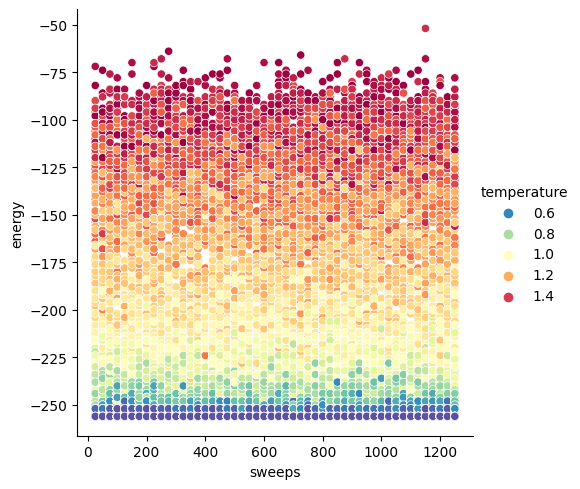

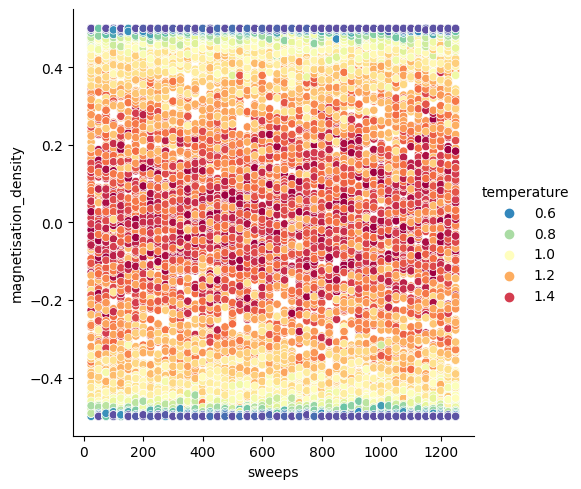

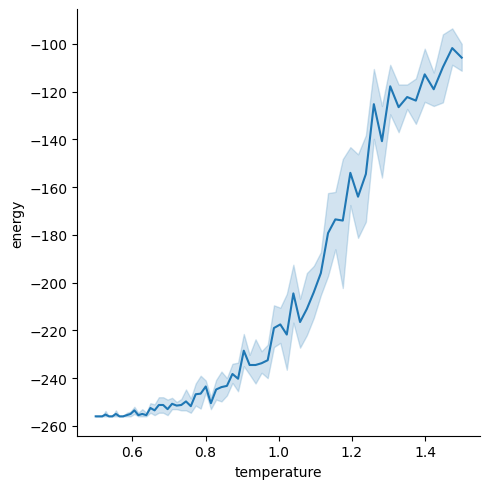

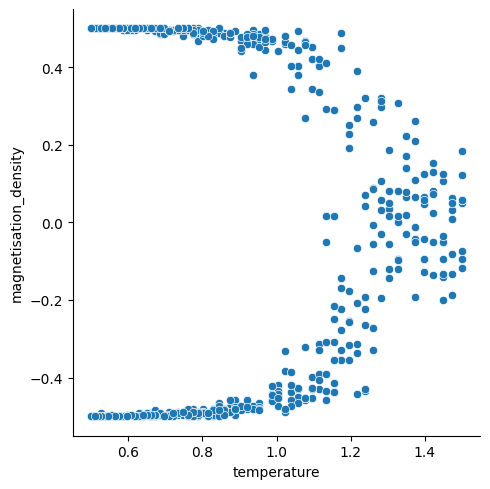

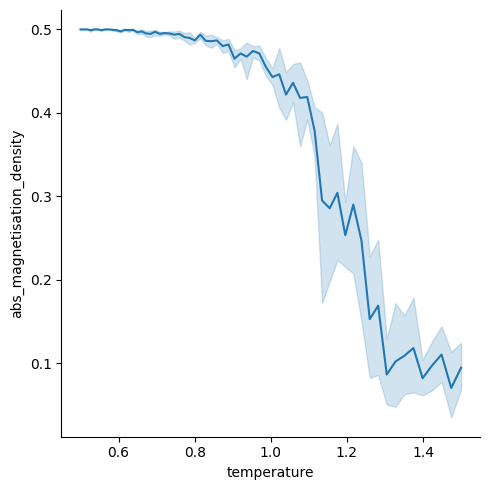

In [13]:
sns.relplot(
    data=df,
    x="sweeps",
    y="energy",
    hue="temperature",
    palette="Spectral_r",
)
sns.relplot(
    data=df,
    x="sweeps",
    y="magnetisation_density",
    hue="temperature",
    palette="Spectral_r",
)

last_sweeps = df[df["sweeps"] == np.max(df["sweeps"])]
sns.relplot(
    data=last_sweeps,
    x="temperature",
    y="energy",
    # hue="beta",
    kind="line",
    # errorbar=None
)
sns.relplot(
    data=last_sweeps,
    x="temperature",
    y="magnetisation_density",
)
sns.relplot(
    data=last_sweeps,
    x="temperature",
    y="abs_magnetisation_density",
    kind="line",
    # errorbar=None
)

In [14]:
df[df["steps"] == np.max(df["steps"])]

,steps,sweeps,state_id,energy,magnetisation_density,beta,temperature,abs_magnetisation_density
25342,319788,1250,254,-256.0,-0.5,1.965426,0.508796,0.5
25343,319788,1250,255,-256.0,-0.5,2.000000,0.500000,0.5


In [15]:
temp_states = states_list[: c.n_temps]


@interact(value=0, min=0, max=len(temp_states))
def update(i=(0, len(temp_states) - 1)):
    fig = temp_states[i].plot()
    fig.set_size_inches(10, 10)
    fig.dpi = 100
    fig.show()

interactive(children=(IntSlider(value=31, description='i', max=63), Output()), _dom_classes=('widget-interact'…

In [16]:
@transforms(in_axes=(0, 0, None, None), out_axes=0)
def measure_states(key, state, num=1, sweeps=0):
    return state.measure(rng_key=key, num=num, sweeps=sweeps)


keys = k.shaped(states.vectorisation_shape)
equil_measurements = measure_states(keys, states, 16, 50)

In [17]:
measurement_keys = [
    "steps",
    "sweeps",
    "state_id",
    "energy",
    "magnetisation_density",
]
eq_measurements = {key: [] for key in measurement_keys}
for key in measurement_keys:
    data = getattr(equil_measurements, key).flatten().tolist()
    eq_measurements[key].extend(data)


@ft.cache
def id_to_beta(id_):
    idx = np.argwhere(states.id_ == id_).flatten()
    idx = tuple(idx)
    return float(states.env.beta[idx])


eq_df = pd.DataFrame(eq_measurements)
eq_df["beta"] = eq_df["state_id"].apply(id_to_beta)
eq_df["temperature"] = 1.0 / eq_df["beta"]
eq_df

,steps,sweeps,state_id,energy,magnetisation_density,beta,temperature
0,14942,1300,0,-126.0,0.062500,0.666667,1.5
1,14587,1300,0,-116.0,0.097656,0.666667,1.5
2,14688,1300,0,-106.0,-0.132812,0.666667,1.5
3,14567,1300,0,-94.0,-0.105469,0.666667,1.5
4,14715,1300,0,-136.0,0.269531,0.666667,1.5
...,...,...,...,...,...,...,...
8187,331812,1300,511,-256.0,0.500000,2.000000,0.5
8188,331816,1300,511,-256.0,0.500000,2.000000,0.5
8189,331819,1300,511,-252.0,0.496094,2.000000,0.5
8190,331816,1300,511,-256.0,0.500000,2.000000,0.5


In [18]:
# Create two dataframes of different 'shapes'
# sin_df: holds data that is defined on every state
# sum_df: holds data that requires grouping on states


sin_df = eq_df.copy()
sin_df["natural_temperature"] = 1.0 / sin_df["beta"]
sin_df["abs_magnetisation_density"] = np.abs(sin_df["magnetisation_density"])

sum_df = pd.DataFrame()


# Energy - Summarised
sum_df["energies_mean"] = eq_df.groupby(["state_id"])["energy"].mean()
sum_df["energies_var"] = eq_df.groupby(["state_id"])["energy"].var()

# Magnetisation Density - Summarised
sum_df["mag_dens_mean"] = eq_df.groupby(["state_id"])["magnetisation_density"].mean()
sum_df["mag_dens_var"] = eq_df.groupby(["state_id"])["magnetisation_density"].var()

# # Index
sum_df["state_id"] = sum_df.index

# Temperature + Coldness
sum_df["beta"] = sum_df["state_id"].apply(id_to_beta)
sum_df["temperature"] = beta_to_temp(sum_df["beta"])
sum_df["natural_temperature"] = 1.0 / sum_df["beta"]

# Heat Capacity
sum_df["heat_cap_gradient"] = np.abs(
    np.gradient(sum_df["energies_mean"], sum_df["temperature"])
)
sum_df["heat_cap_fluctuation"] = sum_df["energies_var"] / (
    constants.Boltzmann * np.square(sum_df["temperature"])
)

# Magnetic Susceptibility
sum_df["mag_sus_gradient"] = np.abs(
    np.gradient(sum_df["mag_dens_mean"], sum_df["temperature"])
)
sum_df["mag_sus_fluctuation"] = sum_df["mag_dens_var"] / (
    constants.Boltzmann * np.square(sum_df["temperature"])
)

# Binder cumulant
sin_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
sin_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
sin_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

sum_df["mag_1_mean"] = sin_df.groupby("state_id")["mag_1"].mean()
sum_df["mag_2_mean"] = sin_df.groupby("state_id")["mag_2"].mean()
sum_df["mag_4_mean"] = sin_df.groupby("state_id")["mag_4"].mean()


# mag_2_mean = np.mean(mag_2)
# mag_4_mean = np.mean(mag_4)

sum_df["binder_2"] = 1 - sum_df["mag_2_mean"] / np.square(sum_df["mag_1_mean"])
sum_df["binder_4"] = 1.0 / 3.0 - sum_df["mag_4_mean"] / (
    3.0 * np.square(sum_df["mag_2_mean"])
)

In [19]:
sum_df

,energies_mean,energies_var,mag_dens_mean,mag_dens_var,state_id,beta,temperature,natural_temperature,heat_cap_gradient,heat_cap_fluctuation,mag_sus_gradient,mag_sus_fluctuation,mag_1_mean,mag_2_mean,mag_4_mean,binder_2,binder_4
state_id,,,,,,,,,,,,,,,,,
0,-106.000,361.066667,0.018555,1.607564e-02,0,0.666667,1.086446e+23,1.500000,3.527413e-21,2.215584e-21,9.619272e-24,9.864365e-26,0.104980,0.015415,0.000721,-0.398724,-0.677592
1,-112.625,289.450000,0.000488,1.062800e-02,1,0.678394,1.067664e+23,1.474069,1.850806e-21,1.839166e-21,7.307641e-24,6.753036e-26,0.077637,0.009964,0.000298,-0.653099,-0.667704
2,-113.000,212.800000,0.044678,1.468500e-02,2,0.690328,1.049207e+23,1.448587,5.525677e-22,1.400122e-21,8.963948e-25,9.662021e-26,0.101318,0.015763,0.000587,-0.535573,-0.453663
3,-114.625,367.850000,-0.001221,1.064192e-02,3,0.702472,1.031069e+23,1.423545,2.884622e-21,2.506177e-21,3.513254e-23,7.250385e-26,0.066650,0.009978,0.000518,-1.246213,-1.401538
4,-123.250,326.866667,-0.081055,1.607971e-02,4,0.714829,1.013245e+23,1.398936,9.849112e-22,2.305994e-21,5.679697e-24,1.134399e-25,0.120605,0.021645,0.000996,-0.488043,-0.375215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,-256.000,0.000000,0.375000,1.166667e-01,507,1.865248,3.883114e+22,0.536122,1.685238e-22,0.000000e+00,7.283247e-23,5.604066e-24,0.500000,0.250000,0.062500,0.000000,0.000000
508,-255.500,1.866667,-0.312012,1.623065e-01,508,1.898060,3.815986e+22,0.526854,1.310259e-23,9.284744e-23,6.509850e-22,8.073075e-24,0.499512,0.249514,0.062259,-0.000007,-0.000009
509,-256.000,0.000000,-0.500000,0.000000e+00,509,1.931449,3.750019e+22,0.517746,1.333356e-23,0.000000e+00,9.223791e-23,0.000000e+00,0.500000,0.250000,0.062500,0.000000,0.000000


In [20]:
sin_df

,steps,sweeps,state_id,energy,magnetisation_density,beta,temperature,natural_temperature,abs_magnetisation_density,mag_1,mag_2,mag_4
0,14942,1300,0,-126.0,0.062500,0.666667,1.5,1.5,0.062500,0.062500,0.003906,0.000015
1,14587,1300,0,-116.0,0.097656,0.666667,1.5,1.5,0.097656,0.097656,0.009537,0.000091
2,14688,1300,0,-106.0,-0.132812,0.666667,1.5,1.5,0.132812,0.132812,0.017639,0.000311
3,14567,1300,0,-94.0,-0.105469,0.666667,1.5,1.5,0.105469,0.105469,0.011124,0.000124
4,14715,1300,0,-136.0,0.269531,0.666667,1.5,1.5,0.269531,0.269531,0.072647,0.005278
...,...,...,...,...,...,...,...,...,...,...,...,...
8187,331812,1300,511,-256.0,0.500000,2.000000,0.5,0.5,0.500000,0.500000,0.250000,0.062500
8188,331816,1300,511,-256.0,0.500000,2.000000,0.5,0.5,0.500000,0.500000,0.250000,0.062500
8189,331819,1300,511,-252.0,0.496094,2.000000,0.5,0.5,0.496094,0.496094,0.246109,0.060570
8190,331816,1300,511,-256.0,0.500000,2.000000,0.5,0.5,0.500000,0.500000,0.250000,0.062500


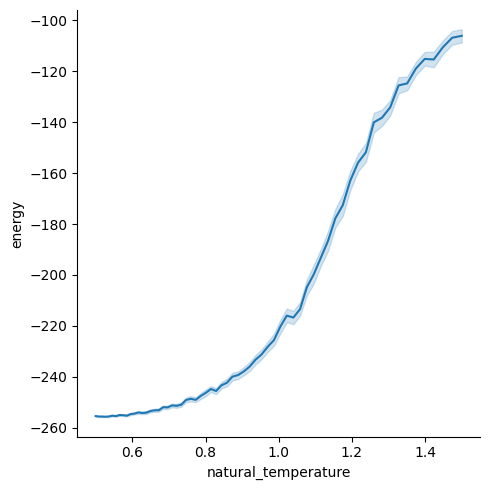

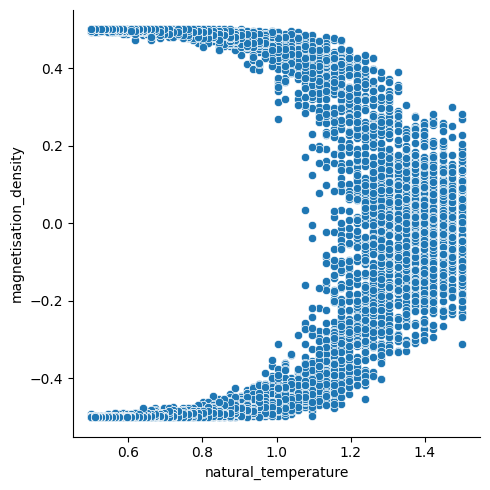

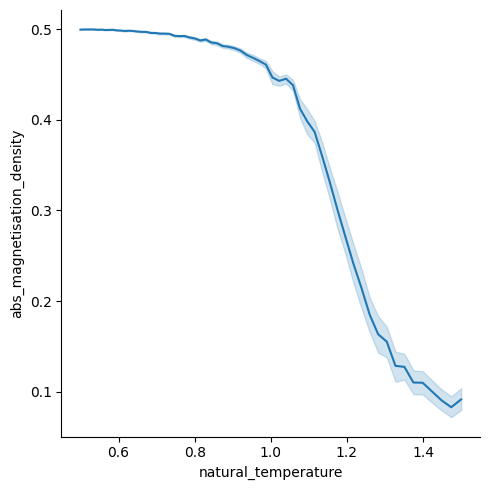

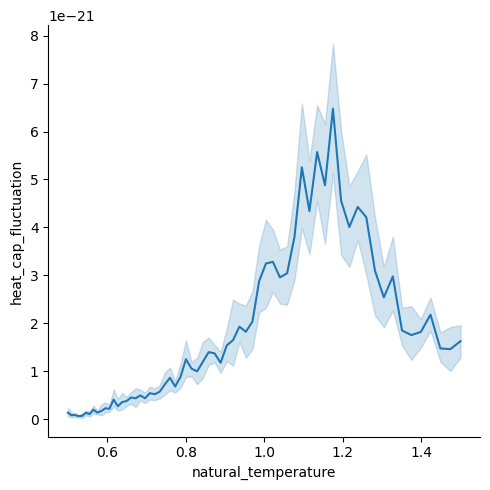

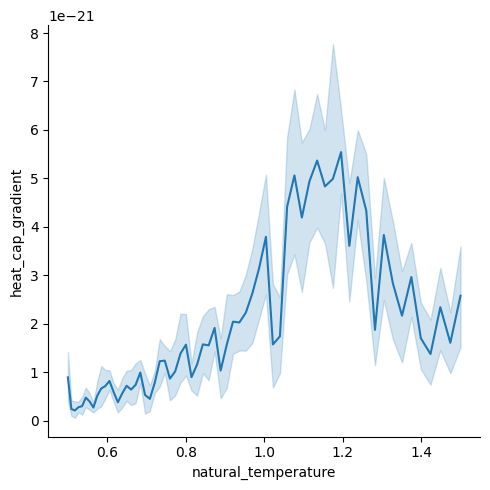

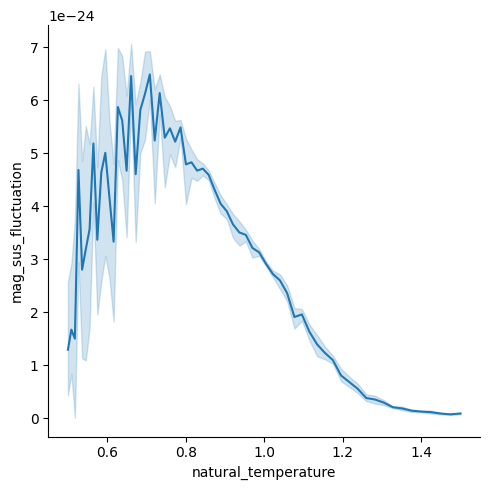

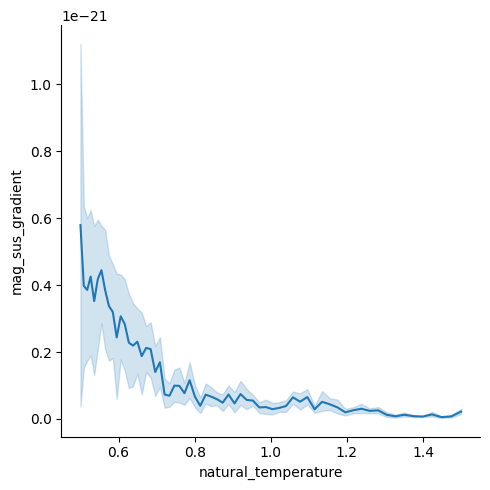

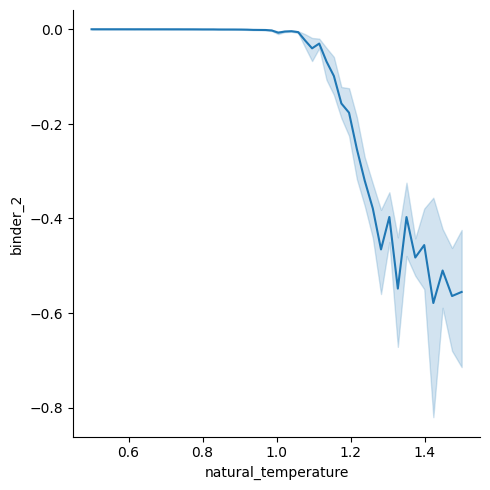

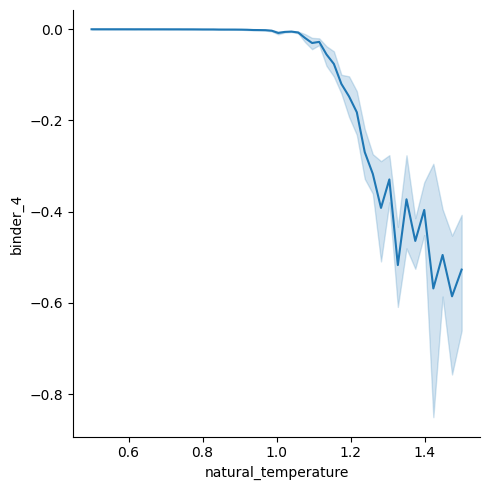

In [21]:
sns.relplot(
    data=sin_df,
    x="natural_temperature",
    y="energy",
    kind="line",
)
sns.relplot(
    data=sin_df,
    x="natural_temperature",
    y="magnetisation_density",
    # kind="line",
)
sns.relplot(
    data=sin_df,
    x="natural_temperature",
    y="abs_magnetisation_density",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="heat_cap_fluctuation",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="heat_cap_gradient",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="mag_sus_fluctuation",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="mag_sus_gradient",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="binder_2",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="binder_4",
    kind="line",
)